- url: https://colab.research.google.com/github/cafrii/fastai_course22p2/blob/master/nbs/04_minibatch_training.ipynb

- review history
  - 2025.5.17, 시간이 촉박해서 대충 봤음.
  - 2025.5.18, L13 역전파 강의에서 다루고 있고, 그 다음 L14 에서도 한번 더 다룬다.

In [ ]:
#| default_exp training

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [ ]:
# 데이터 준비하기. 원본 코드는 01_matmul.ipynb 에 있음.
#
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 May 17 06:31 mnist.pkl.gz


In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Initial setup

### Data

In [ ]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]

    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [ ]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$$

In practice, we will need the log of the softmax when we calculate the loss.

In [ ]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [ ]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

Note that the formula

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$

gives a simplification when we compute the log softmax:

In [ ]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [ ]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us.

In [ ]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [ ]:
test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [ ]:
y_train[:3]

tensor([5, 0, 4])

In [ ]:
sm_pred[0,5],sm_pred[1,0],sm_pred[2,4]

(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

In [ ]:
sm_pred[[0,1,2], y_train[:3]]

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [ ]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [ ]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

Then use PyTorch's implementation.

In [ ]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [ ]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [ ]:
loss_func = F.cross_entropy

In [ ]:
bs=50                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [ ]:
yb = y_train[0:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])

In [ ]:
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [ ]:
preds.argmax(dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5])

In [ ]:
#|export
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [ ]:
accuracy(preds, yb)

tensor(0.08)

In [ ]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for

In [ ]:
#|export
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [ ]:
xb,yb = x_train[:bs],y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.30, 0.08


In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()
    report(loss, preds, yb)

0.12, 0.98
0.12, 0.94
0.08, 0.96


## Using parameters and optim

### Parameters

In [ ]:
# 모듈을 아래처럼 Module()을 그냥 그대로 사용하진 않는다. 여기서는 연습을 위해서이다.
#
m1 = nn.Module()
m1.foo = nn.Linear(3,4)
# 이렇게 그냥 "속성"으로 만들기만 하면 된다. 이름은 뭐래도 상관 없다.
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [ ]:
# 이 모듈 'm1'에 있는 모든 이름이 있는 자식을 보여달라.
#
list(m1.named_children())
# 각 요소가 ('name', layer) 의 튜플로 표시되고 있다.

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [ ]:
# "list()" 와 같이 감싸는 것이 필수이다. 이게 없으면 그냥 제너레이터 객체 자체가 표시된다.
m1.named_children()

<generator object Module.named_children>

In [ ]:
# 이 모듈 'm1'의 모든 파라미터(매개변수)를 출력하라.
#
list(m1.parameters())
#
# 두 개의 파라미터가 출력되는데..
#  - 하나는 4x3 텐서 (이것은 가중치)
#  - 하나는 길이 4의 벡터 (편향)

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [ ]:
# 보통은 아래와 같이 nn.Module 을 계승해서 클래스를 만들어 사용한다.
# 이것이 커스텀 pytorch 모듈을 만드는 가장 일반적인 모습이다.

class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        # 은닉 층은 1개만 사용하는 것을 전제로 하고 있고, hidden activation 수만 설정하도록 하고 있음.
        # 은닉 층의 "노드 수" 라고 보면 될 듯.
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()

    # 처음에 Module 스터디 할 때는 __call__(self, x) 를 정의했었지만
    # nn.Module 을 확장해서 쓰고 있으므로 forward() 를 override 해서 사용하는 게 낫다.
    #
    def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [ ]:
# nh 는 이 장 맨 앞에서 50 으로 정했었음.
model = MLP(m, nh, 10)
model.l1
# 참고로, '모듈' 과 '모델' 용어가 혼용되고 있는데, 인스턴스화 된 가장 바깥 계층 개체 (가장 자식 클래스)는
# 모델이라고 부를 수 있다.
# 파이토치에서는 "모든 것이 모듈" 이므로, 이 model 역시 nn.Module 이라고 볼 수 있다.

Linear(in_features=784, out_features=50, bias=True)

In [ ]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
for name,l in model.named_children(): print(f"{name}: {l}")
# 앞에서도 확인했지만, 이 named_children()은
#  (name,layer) 튜플 시퀀스를 리턴해두는 이터레이터.

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [ ]:
for p in model.parameters(): print(p.shape)
# 각 파라미터가 어느 계층의 무엇을 의미하는지는, 이름이 따로 없으니 shape 으로 유추할 수 밖에 없다.
#
# torch.Size([50, 784])  <- l1 의 가중치
# torch.Size([50])       <- l1 의 bias
# torch.Size([10, 50])   <- l2 의 가중치
# torch.Size([10])       <- l2 의 bias

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                # 실제로 수정한 부분은 아래 두 줄.
                for p in model.parameters(): p -= p.grad * lr
                # 이 부분이 아주 간단해졌다. 기존에는 각 layer들을 순회하면서, 그 layer안의
                # 'weight' 라는 속성을 추출하고 각각 별도로 grad update를 해 줬음.
                ''' 기존 코드:
                for l in model.layers:
                    if hasattr(l, 'weight'):
                        l.weight -= l.weight.grad * lr
                        l.bias   -= l.bias.grad   * lr
                '''
                model.zero_grad()
                # 이 코드도 예전엔 각 파라미터들에게 zero-ize 해 주었으나, 이젠 한번에 끝낸다.
                #    l.weight.grad.zero_()
                #    l.bias  .grad.zero_()

        report(loss, preds, yb)

In [ ]:
fit()

# 비교를 위해, 모델 생성 후 fit() 실행 전에 report()를 한번 수행해 놓으면 바로 비교 가능하다.
# xb,yb = x_train[:bs],y_train[:bs]
# preds = model(xb)
# report(loss_func(preds, yb), preds, yb)
# -> 2.30, 0.08    # 손실 2.3, 정확도 8%

0.19, 0.96
0.11, 0.96
0.04, 1.00


In [ ]:
#-------------
# 어떻게 모델과 파라미터를 nn.Module 에서 자동으로 알아챌 수 있었는지에 대한 내부 동작 원리를 설명한다.

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [ ]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)

    def __setattr__(self,k,v):
        # k 는 속성의 이름, v 는 속성에 할당된 객체. (= 의 오른쪽 부분)
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)

    def __repr__(self): return f'{self._modules}'

    def parameters(self):
        for l in self._modules.values(): yield from l.parameters()
        # `yield from ...`는 다음과 같은 코드를 더욱 단축 시킨 것이다.
        # for p in l.parameters(): yield p

In [ ]:
mdl = MyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [ ]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering modules

In [ ]:
from functools import reduce

We can use the original `layers` approach, but we have to register the modules.

In [ ]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [ ]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
          # layers 라는 속성도 모듈로 처리하려고 시도할 것 같은데, 괜찮나?
          # add_module() 이란 메소드가 한번이라도 불리면 자동 모듈 인식 기능은 비활성화 되나?
          # 그게 아니면 layers 속성이 nn.Module 인스턴스가 아니라는 것을 스스로 감지한 건가?
          #
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

    def forward(self, x): return reduce(lambda val,layer: layer(val), self.layers, x)
    '''
      reduce(func, sequence[, initial]) -> value
    '''


In [ ]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
model(xb).shape

torch.Size([50, 10])

### nn.ModuleList

`nn.ModuleList` does this for us.

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for l in self.layers: x = l(x)
        return x
        # 위 두 라인은 아래와 동일하다.
        # return reduce(lambda val,layer: layer(val), self.layers, x)

In [ ]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [ ]:
fit()

0.12, 0.96
0.11, 0.96
0.07, 0.98


### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.16, 0.94
0.13, 0.96
0.08, 0.96


(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

In [ ]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

In [ ]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr

    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr
        # 요약하면, 모든 grad 정보와 lr 을 이용하여 params 를 업데이트하는 작업을 모두 여기서 한다.

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()
        # p.grad.zero_() 와 같이 사용하였는데, 이럴 경우 torch.no_grad()로 감싸야 했다.
        # p.grad.data.zero_() 는 no_grad 없이 사용할 수 있다.

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [ ]:
opt = Optimizer(model.parameters())

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):            # 각 배치의 시작점
        s = slice(i, min(n,i+bs))        # 슬라이스
        xb,yb = x_train[s],y_train[s]    # 트레이닝 세트에서 x, y 슬라이싱
        preds = model(xb)                # 예측 수행
        loss = loss_func(preds, yb)      # 손실 계산
        loss.backward()                  # 역전파
        opt.step()                       # 최적화
        opt.zero_grad()                  # 그래디언트 초기화
    report(loss, preds, yb)           # 에포크 진행 상황 표시

0.18, 0.94
0.13, 0.96
0.11, 0.94


PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later)

In [ ]:
from torch import optim

In [ ]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [ ]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.33, grad_fn=<NllLossBackward0>)

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.12, 0.98
0.09, 0.98
0.07, 0.98


## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[s]
    yb = y_train[s]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[s]
```

In [ ]:
#|export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

# Dataset 은, 입력 변수와 종속 변수 둘 다를 포함하는 데이터 덩어리를 말한다.
# 훈련용 과 검증용 각각 존재할 수 있다.
# 질문:  ds[i:i+bs] 와 같이 슬라이스를 하면 __getitem__ 에서 대응할 수 있는가?

In [ ]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [ ]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [ ]:
model,opt = get_model()

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i:min(n,i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.17, 0.96
0.11, 0.94
0.09, 0.96


### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
# 이런 식으로 사용할 수 있게끔 만들어보자는 말이다.
for xb,yb in train_dl:
    ...
```

In [ ]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [ ]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

# 이 문서 전체적으로 bs=50 을 사용하고 있다.

In [ ]:
xb,yb = next(iter(valid_dl))
xb.shape

torch.Size([50, 784])

In [ ]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4])

tensor(3)

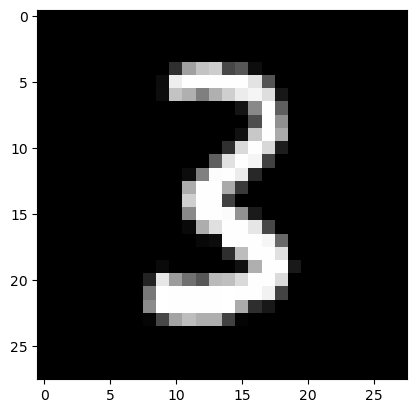

In [ ]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [ ]:
model,opt = get_model()

In [ ]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:  # 바뀐 부분은 바로 이곳.
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [ ]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.11, 0.96
0.08, 0.96
0.06, 0.96


(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [ ]:
import random

In [ ]:
class Sampler():
    def __init__(self, ds, shuffle=False): self.n,self.shuffle = len(ds),shuffle
    # 이 Sampler 클래스에서 ds 는 그냥 길이 정보만 파악하는 용도로만 사용된다. 저장조차 하지 않는다.

    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [ ]:
from itertools import islice

In [ ]:
ss = Sampler(train_ds)

In [ ]:
it = iter(ss)
for o in range(5): print(next(it))

0
1
2
3
4


In [ ]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [ ]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[23241, 48397, 22315, 6710, 35026]

In [ ]:
import fastcore.all as fc

In [ ]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [ ]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[12257, 25230, 12990, 40776],
 [47107, 32853, 39167, 47750],
 [42548, 36662, 15709, 31127],
 [7489, 27472, 46202, 18724],
 [2249, 38893, 25321, 32710]]

In [ ]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [ ]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)
    # 이 코드 줄이 잘 이해가 안된다.
    # next(iter(dl)) 이 리턴할 것으로 예상되는 것은 (xb,yb) 튜플이다.
    # 1. `for b in self.batchs`: 50개 씩의 인덱스 목록을 받음.
    # 2. `self.ds[i] for in in b`: 50개의 랜덤 인덱스로 ds[] 인덱싱. (x,y) 형태일 것임.
    #  TODO...

In [ ]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [ ]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

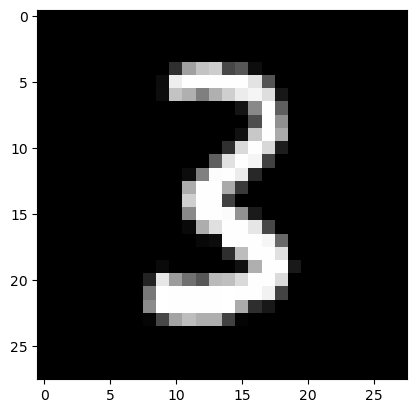

In [ ]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [ ]:
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [ ]:
model,opt = get_model()

In [ ]:
fit()

0.27, 0.04
0.15, 0.02
0.01, 0.12


### Multiprocessing DataLoader

In [ ]:
import torch.multiprocessing as mp
# 파이썬에 이미 multiprocessing 라이브러리가 있지만 torch tensor 에는 잘 동작하지 않아서
# pytorch 에서 동일한 인터페이스를 유지하면서 내용을 새롭게 다시 구현하였음.

from fastcore.basics import store_attr

In [ ]:
train_ds[[3,6,8,1]]

# 왜 갑자기 인덱스로 배열이 등장하는가??
# 우리가 구현한 __get_index__ 는 이걸 처리 할 수 있는가?
#    def __getitem__(self, i): return self.x[i],self.y[i]
# x,y 가 리스트라면 안될거 같고.. 혹시 torch.Tensor 는 지원 가능할지도..

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [ ]:
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [ ]:
for o in map(train_ds.__getitem__, ([3,6],[8,1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [ ]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [ ]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [ ]:
xb,yb = next(it)
xb.shape,yb.shape

### PyTorch DataLoader

In [ ]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [ ]:
train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [ ]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [ ]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.10, 0.06
0.10, 0.04
0.27, 0.06


(tensor(0.05, grad_fn=<NllLossBackward0>), tensor(0.98))

PyTorch can auto-generate the BatchSampler for us:

In [ ]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

PyTorch can also generate the Sequential/RandomSamplers too:

In [ ]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [ ]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


0.21, 0.14


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


0.15, 0.16


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


0.05, 0.10


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

Our dataset actually already knows how to sample a batch of indices all at once:

In [ ]:
train_ds[[4,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

...that means that we can actually skip the batch_sampler and collate_fn entirely:

In [ ]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [ ]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [ ]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()            # 처음 등장하는 메소드임. 무슨 준비 작업을 하는건가?
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [ ]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))
            # 검증용 dl 에 bs 두배를 하는 이유는 역전파 과정이 없어서 메모리 절반이 남기 때문.

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [ ]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()

In [ ]:
%time loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.0951265140157193 0.9733000087738037
1 0.09963013818487525 0.9722000092267991
2 0.1106003435049206 0.969400007724762
3 0.09982822934631258 0.9742000102996826
4 0.12104855466226581 0.9687000066041946
CPU times: user 1.38 s, sys: 487 ms, total: 1.87 s
Wall time: 1.54 s


## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()